In [1]:
%config IPCompleter.greedy=True

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_regression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random
import os

from pytorch_tabular import TabularModel
from pytorch_tabular.models import CategoryEmbeddingModelConfig, NodeConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
import torchmetrics

### Read in the data

Lines labeled with errors are malformed due to the extra comma, so we ignore them.

In [3]:
df = pd.read_csv('finantier_data_technical_test_dataset.csv', header=None, error_bad_lines=False, warn_bad_lines=True, skip_blank_lines=True)

b'Skipping line 2: expected 21 fields, saw 22\nSkipping line 4: expected 21 fields, saw 22\nSkipping line 29: expected 21 fields, saw 22\nSkipping line 85: expected 21 fields, saw 22\n'


In [4]:
df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Default
1,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7040,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.8,1990.5,No
7041,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.2,7362.9,No
7042,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.6,346.45,No
7043,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.4,306.6,Yes


In [5]:
#Setting the first row as the header.
new_header = df.iloc[0] #grab the first row for the header
df = df[1:] #take the data less the header row
df.columns = new_header #set the header row as the df header

In [6]:
n_rows, n_cols = df.shape
print(f"# of rows is {n_rows}")
print(f"# of columns is {n_cols}")

# of rows is 7044
# of columns is 21


In [7]:
#Some rows with nothing but commas are read in with NaN values. Drop these rows
df.dropna(subset = ["customerID"], inplace=True)

<ipython-input-7-22908298bb2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset = ["customerID"], inplace=True)


In [8]:
n_rows, n_cols = df.shape
print(f"# of rows is {n_rows}")
print(f"# of columns is {n_cols}")

# of rows is 7040
# of columns is 21


In [9]:
#Some values are read in as whitespace, replace these with NaN
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4383: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [10]:
df[df.isna().any(axis=1)]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Default
490,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
755,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
938,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1084,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1342,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3333,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3828,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4382,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20,NaN,No
5220,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.7,NaN,No
6672,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In [11]:
#We see that all the NaN values are in the TotalCharges column
df.isnull().sum()

0
customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Default              0
dtype: int64

In [12]:
#We drop those rows since only 11 have NaN values
df.dropna(inplace=True)

<ipython-input-12-ff503e7d1da4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [13]:
#Change the datatype for numerical variables
df[["tenure", "MonthlyCharges", "TotalCharges"]] = df[["tenure", "MonthlyCharges", "TotalCharges"]].apply(pd.to_numeric)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [14]:
df.dtypes

0
customerID           object
gender               object
SeniorCitizen        object
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Default              object
dtype: object

In [15]:
#Drop ID column
df.drop(columns=["customerID"], inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [16]:
df

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Default
1,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7040,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7041,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No
7042,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7043,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


### Default rate

<AxesSubplot:title={'center':'Default'}>

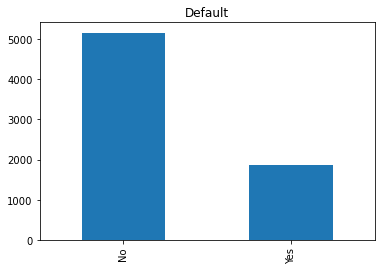

In [17]:
df["Default"].value_counts().plot(kind='bar', title='Default')

We have a binary classification problem with a slightly unbalanced target.

In [18]:
#Convert the target variable in a binary numeric variable
df['Default'].replace(to_replace='Yes', value=1, inplace=True)
df['Default'].replace(to_replace='No',  value=0, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:4576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### One hot encode catagorical variables

In [19]:
df_dummies = pd.get_dummies(df)
df_dummies.head()

,tenure,MonthlyCharges,TotalCharges,Default,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
1,1,29.85,29.85,0,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
2,2,53.85,108.15,1,0,1,1,0,1,0,...,0,1,0,0,0,1,0,0,0,1
3,45,42.30,1840.75,0,0,1,1,0,1,0,...,0,0,1,0,1,0,1,0,0,0
4,2,70.70,151.65,1,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
5,8,99.65,820.50,1,1,0,1,0,1,0,...,1,1,0,0,0,1,0,0,1,0


<AxesSubplot:>

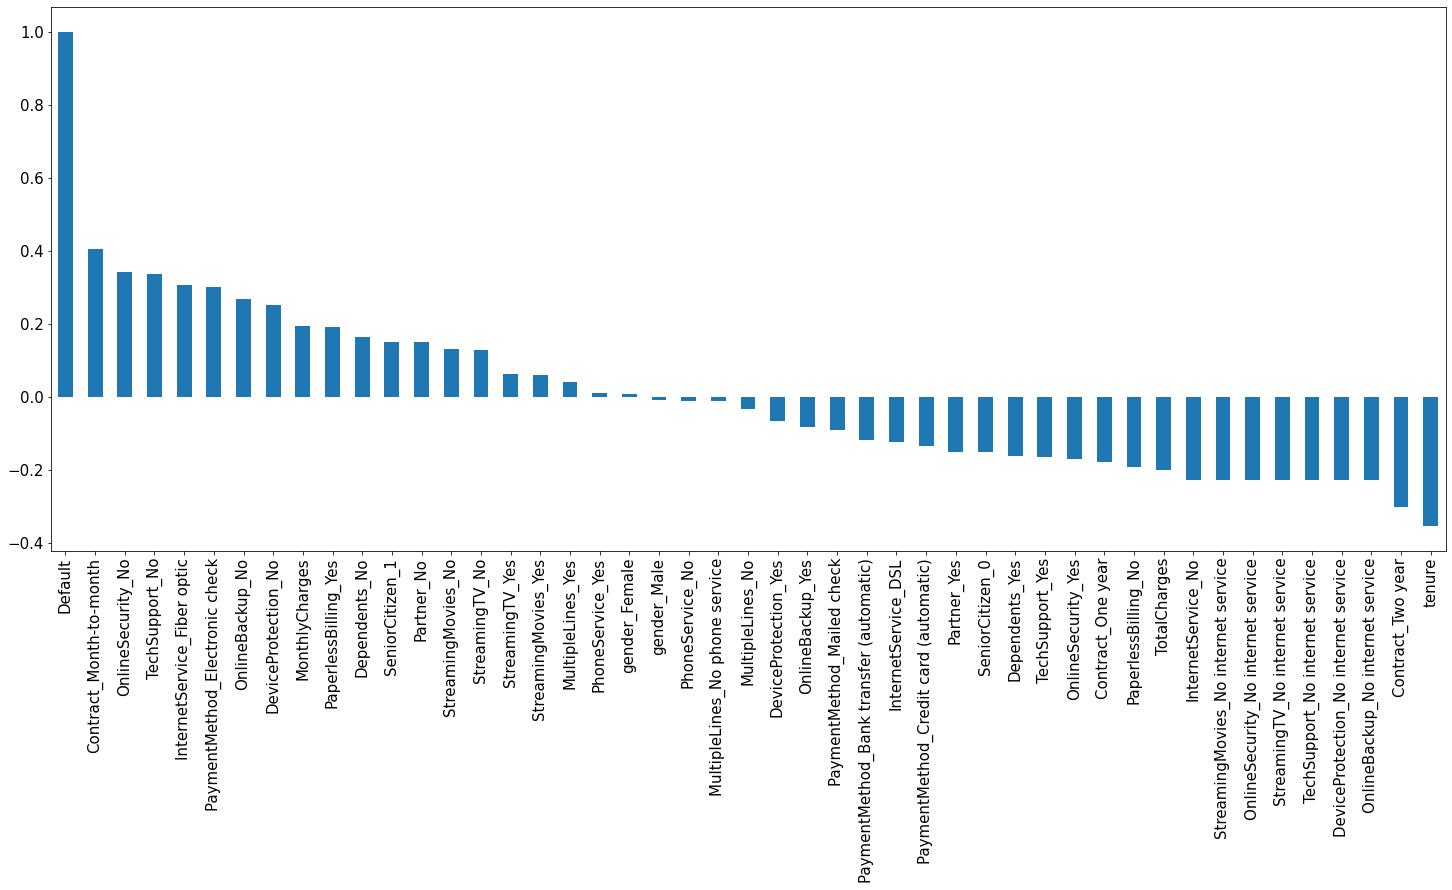

In [20]:
#Get the correlation of features to Defaults
plt.figure(figsize=(25, 10))
df_dummies.corr()['Default'].sort_values(ascending = False).plot(kind='bar', fontsize=15)

Month to month contracts is the most positively correlated with defaults. Whereas tenure and two year contracts are the most negatively correlated with defaults.

It seems also that having no internet connection is negatively related to defaults.

In [21]:
n_rows, n_cols = df.shape
print(f"# of rows is {n_rows}")
print(f"# of columns is {n_cols}")

# of rows is 7029
# of columns is 20


In [22]:
datatypes = df.dtypes
categorical_features = datatypes[datatypes=="object"].index
numerical_features = datatypes[datatypes!="object"].index

## Exploring catagorical variables

### Demographics

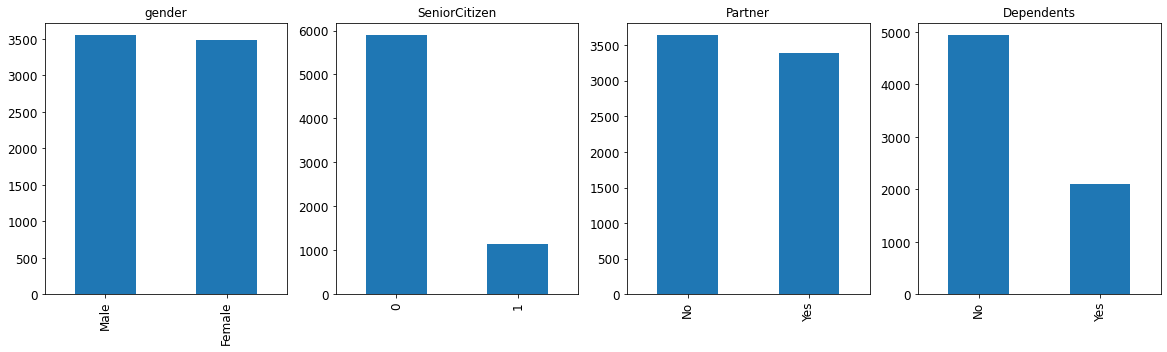

In [23]:
n = len(categorical_features)

r, c = 1,4
fig, ax = plt.subplots(r, c, figsize=(20,5))

for i in range(4):
    feature = categorical_features[i]
    ax = plt.subplot(r,c,i+1)
    ax.set_title(feature)
    df[feature].value_counts().plot(kind='bar', fontsize=12)

plt.show()

Gender and partner distribution are both rather balanced. Most of the customers are not senior citizens and do not have dependents.

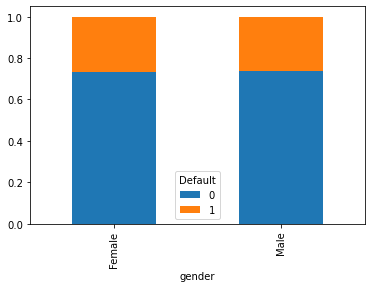

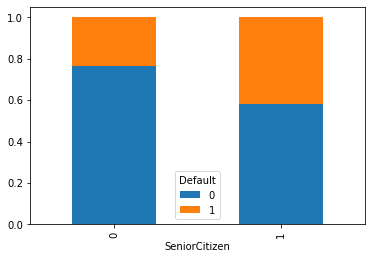

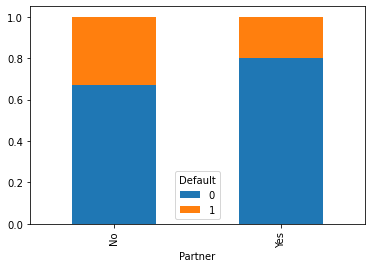

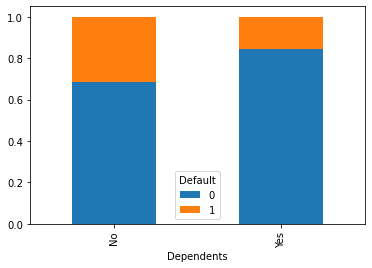

In [24]:
for i in range(4):
    feature = categorical_features[i]
    fig = pd.crosstab(df[feature], df.Default, normalize='index').plot.bar(stacked=True)

plt.show()

It looks like those without dependents, senior citizens, and without partners are more likely to default.

### Services

<AxesSubplot:xlabel='PhoneService'>

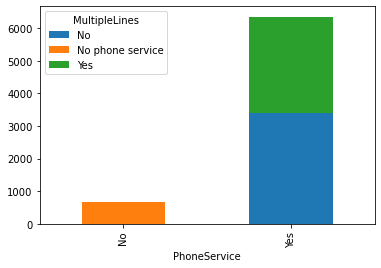

In [25]:
table = pd.crosstab(df.PhoneService, df.MultipleLines)
table.plot.bar(stacked=True)

Majority of the customers have a phone service. Of those that do, there is quite an even split between those with multiple line and those with one line only.

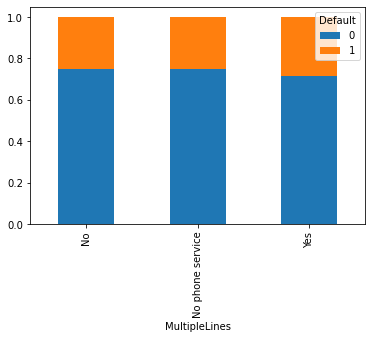

In [26]:
table = pd.crosstab(df.MultipleLines, df.Default, normalize='index')
ax = table.plot.bar(stacked=True)

The type of phone service does not seem predictive of the default rate

<AxesSubplot:title={'center':'InternetService'}>

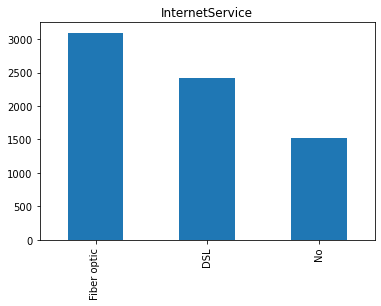

In [27]:
df['InternetService'].value_counts().plot(kind='bar', title='InternetService')

Majority of the customers have internet service with fiber optic being the most popular.

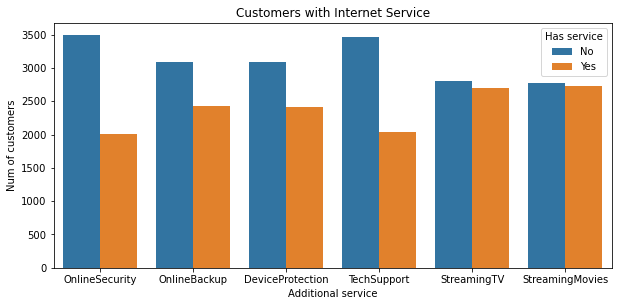

In [28]:
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
df1 = pd.melt(df[df["InternetService"] != "No"][cols]).rename({'value': 'Has service'}, axis=1)
plt.figure(figsize=(10, 4.5))
ax = sns.countplot(data=df1, x=0, hue='Has service')
ax.set(xlabel='Additional service', ylabel='Num of customers', title='Customers with Internet Service')
plt.show()

Of those that have internet service, there is an even split between customers that opting in for streaming services. For the other services, majority choose not to have them.

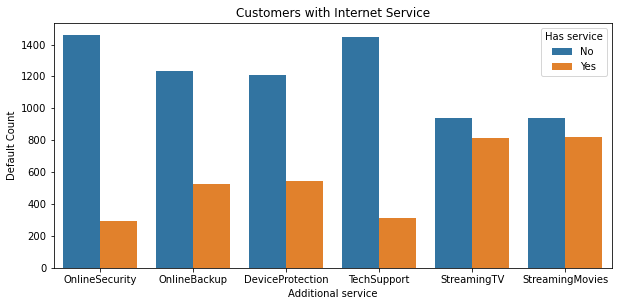

In [29]:
plt.figure(figsize=(10, 4.5))
df1 = df[(df.InternetService != "No") & (df.Default == 1)]
df1 = pd.melt(df1[cols]).rename({'value': 'Has service'}, axis=1)
ax = sns.countplot(data=df1, x=0, hue='Has service', hue_order=['No', 'Yes'])
ax.set(xlabel='Additional service', ylabel='Default Count', title='Customers with Internet Service')
plt.show()

Interestingly, the disparity for the first four additional services is greater when considering those that default, which suggests that customers that opt for these protective services are less likely to default.

### Contract Specifications

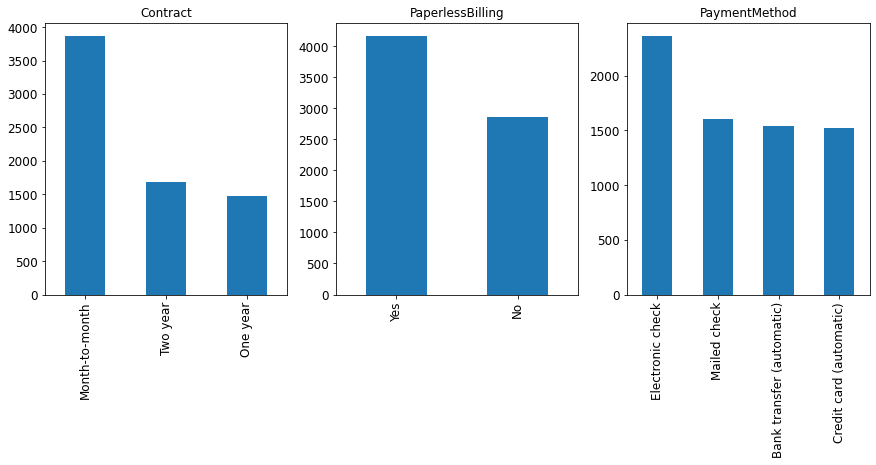

In [30]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))

for i in range(13,16):
    feature = categorical_features[i]
    ax = plt.subplot(r,c,i-11)
    ax.set_title(feature)
    df[feature].value_counts().plot(kind='bar', fontsize=12)

plt.show()

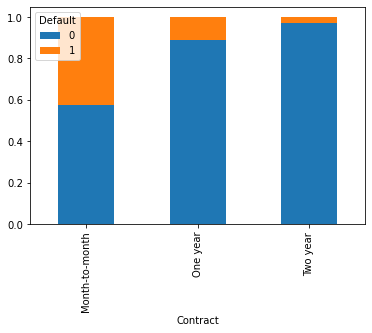

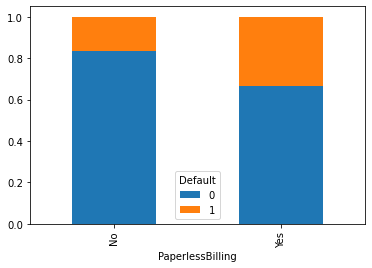

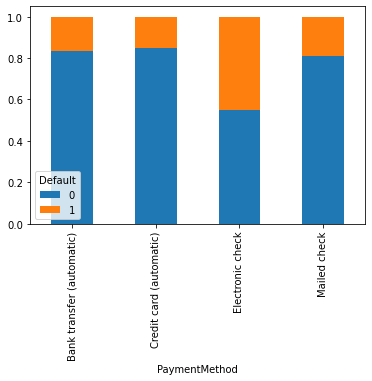

In [31]:
table = pd.crosstab(df.Contract, df.Default, normalize='index')
ax = table.plot.bar(stacked=True)
table = pd.crosstab(df.PaperlessBilling, df.Default, normalize='index')
ax = table.plot.bar(stacked=True)
table = pd.crosstab(df.PaymentMethod, df.Default, normalize='index')
ax = table.plot.bar(stacked=True)

Customers with Month-to-month contracts, paperless billing and electronic checks seem more likely to default.

# Exploring numerical variables

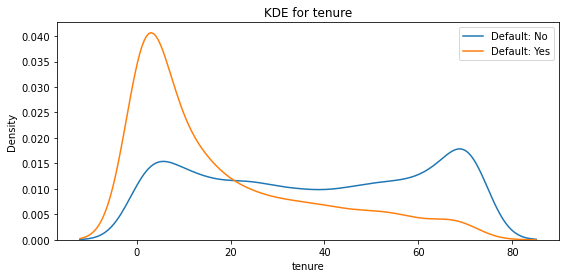

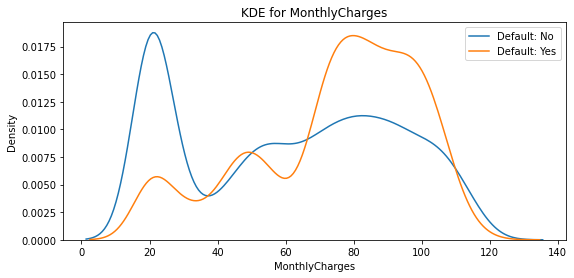

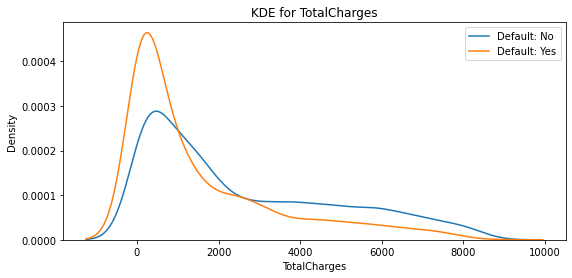

In [32]:
def kdeplot(feature):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(feature))
    ax0 = sns.kdeplot(df[df['Default'] == 0][feature].dropna(), label='Default: No')
    ax1 = sns.kdeplot(df[df['Default'] == 1][feature].dropna(), label='Default: Yes')
    plt.legend()
kdeplot('tenure')
kdeplot('MonthlyCharges')
kdeplot('TotalCharges')

From the kdeplots, we can see that the clients with a shorter tenure and higher monthly charges are more likely to default. The total charges seems to generally follow the trend for tenure since they should be highly correlated.

## Random Forest

Get a gauge of important features and baseline performance with Random Forest. We use accuracy to evaluate the models for this dataset since the dataset is not overly unbalanced at a roughly 70-30% split and it can be argued that it is equally important to predict who will default and who will not default, since a telco would want to sell their services to as many customers that will not default, while also avoiding those that will default. In other words, we want to consider the true negative rate of the models, which is accounted for in Accuracy, but not in F1-score.

In [33]:
y = df_dummies['Default'].values
X = df_dummies.drop(columns = ['Default'])

features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)
model_rf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print(prediction_test)
print (metrics.accuracy_score(y_test, prediction_test))

[1 1 1 ... 0 0 0]
0.7972972972972973


<AxesSubplot:title={'center':'Important Features'}>

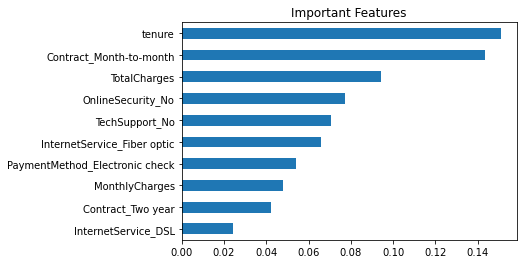

In [35]:
importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh', title='Important Features')

From the Random Forest algorithm, tenure and month to month contracts are the most important predictors to predict if the customer will default. This matches the correlation plot above, where tenure and month to month contracts are the most negatively and positively correlated to Default respectively.

# Using Neural Oblivious Decision Emsembles (NODE)

Node is a new deep learning architecture designed to work with tabular data. The architecture consists of differentiable oblivious decision trees (ODT) that are trained end-to-end by backpropagation. To make the tree outputs differentiable, the authors used continuous counterparts to the splitting feature choice function and the Heaviside function, namely the entmax transformation. NODE allows for multi-layer architecture design, where the outputs of each layer are concatenated with the outputs of the previous layers, and this in turn serves as the input to the next layer. This allows for the learning of both shallow and deep decision rules.

Under the hood, NODE uses the Ordered Target Statistic strategy implemented with CatBoost, which maps each category of a categorical variable to one numeric feature equal to some target statistic, which estimates the expected target y conditioned by the category. Thus for the NODE model, we will not perform one-hot encoding for the categorical features.

In [53]:
df_node = df.copy()
features = df_node.columns.values
df_node

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Default
1,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
5,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7040,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0
7041,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0
7042,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0
7043,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1


In [37]:
train, test = train_test_split(df_node, random_state=42)
train, val = train_test_split(train, random_state=42)

In [38]:
batch_size = 512
steps_per_epoch = int(train.shape[0]/batch_size)
epochs = 50

In [39]:
numerical_features = numerical_features.drop('Default')
numerical_features

Index(['tenure', 'MonthlyCharges', 'TotalCharges'], dtype='object', name=0)

In [40]:
datatypes = df_node.dtypes
categorical_features = datatypes[datatypes == "object"].index

categorical_features

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object', name=0)

In [41]:
data_config = DataConfig(
    target=['Default'], #target should always be a list. Multi-targets are only supported for regression. Multi-Task Classification is not implemented
    continuous_cols=numerical_features.tolist(),
    categorical_cols=categorical_features.tolist(),
)

In [42]:
trainer_config = TrainerConfig(
    auto_lr_find=False,
    batch_size=batch_size,
    max_epochs=epochs,
    early_stopping=None,
    accumulate_grad_batches=2,
    gpus=-1, #index of the GPU to use. -1 means using all available GPUs. None, means CPU
)


In [43]:
optimizer_config = OptimizerConfig(
    lr_scheduler="OneCycleLR", 
    lr_scheduler_params={
        "max_lr":2e-3, 
        "epochs": epochs, 
        "steps_per_epoch":steps_per_epoch})

In [44]:
model_config = NodeConfig(
    task="classification",
    num_layers=2, # Number of Dense NODE Layers
    num_trees=1024, #Number of Trees in each layer
    depth=5, #Depth of each Tree
    embed_categorical=False, #If True, will use a learned embedding, else it will use LeaveOneOutEncoding for categorical columns
    learning_rate = 1e-3)

In [45]:
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

In [46]:
from torch_optimizer import QHAdam
from sklearn.preprocessing import PowerTransformer

In [47]:
tabular_model.fit(train=train, 
                  validation=val,  
                  optimizer=QHAdam, 
                  optimizer_params={"nus": (0.7, 1.0), "betas": (0.95, 0.998)})

Global seed set to 42
C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\ProgramData\Anaconda3\lib\site-packages\torch\_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ..\aten\src\ATen\native\BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: Checkpoint directory saved_models exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU a

Validation sanity check: 0it [00:00, ?it/s]

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
Global seed set to 42
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [49]:
result = tabular_model.evaluate(test)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:69: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_accuracy': 0.7901023626327515}
--------------------------------------------------------------------------------


In [50]:
pred_df = tabular_model.predict(test)
pred_df["prediction"]

Generating Predictions...:   0%|          | 0/4 [00:00<?, ?it/s]

2486    0
6786    0
4648    1
3057    0
4104    0
       ..
6105    0
6189    0
115     0
3053    0
5063    0
Name: prediction, Length: 1758, dtype: int64

In [51]:
tabular_model.save_model('NODEresults')